In [1]:

# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [4]:
# also https://github.com/rkaunismaa/NaturalLanguageProcessingWithTransformers/blob/main/05_text-generation-Gradient.ipynb
# hide
from utils import *
setup_chapter()
     

Using transformers v4.24.0
Using datasets v2.16.1


## Greedy Search Decoding

In [5]:
# hide_output
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

D:\Anaconda\envs\tf-gpu\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\bscho\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [6]:
# hide_output
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.26%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


In [11]:
# greedily search token at each timestep (greedy = max prob)
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
print(input_ids)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

tensor([[12510, 26028,   329,   262, 40748,    12,    74,   654,   739,   262,
          6766, 13723,   329,   262, 33196,    12, 19673,   287,   511, 24350,
           286,  7815, 16431,   329, 40166,  6065, 24312,   284,  4656,  1881,
           329,   262,  3801,  4453,   319,   465,  3223, 19262,   554,   262,
          6379,   286, 29548,   273,   810,   262, 18037,  6486,    13,   628,
           198]], device='cuda:0')
Three Rings for the Elven-kings under the sky Seven for the Dwarf-lords in their
halls of stone Nine for Mortal Men doomed to die One for the Dark Lord on his
dark throne In the Land of Mordor where the Shadows lie.


The Fellowship of the Ring

The


In [17]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


In [10]:
max_length = 254
input_txt = """Three Rings for the Elven-kings under the sky \
Seven for the Dwarf-lords in their halls of stone \
Nine for Mortal Men doomed to die \
One for the Dark Lord on his dark throne \
In the Land of Mordor where the Shadows lie.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

Three Rings for the Elven-kings under the sky Seven for the Dwarf-lords in their
halls of stone Nine for Mortal Men doomed to die One for the Dark Lord on his
dark throne In the Land of Mordor where the Shadows lie.


The Fellowship of the Ring

The Fellowship of the Ring is a novel by J.R.R. Tolkien. It was published in
1954 and is the second of the three volumes of The Lord of the Rings. It was
written in the first person, and is the story of the journey of the Fellowship
of the Ring.

The book is divided into three parts:

The Fellowship of the Ring

The Two Towers

The Return of the King

The Fellowship of the Ring

The Fellowship of the Ring is the first part of the book. It is the story of the
journey of the Fellowship of the Ring. The book begins with Frodo Baggins,
Samwise Gamgee, and Merry Brandybuck on their way to Mordor.

The Fellowship of the Ring

The Fellowship of the Ring is the second part of the book. It is the story of
the journey of the Fellowship of the Ring. The b

## Beam Search Decoding

top-b most probable next tokens

In [12]:
# overall probability of a sequence of 1024 tokens, each p=0.5 -> underflow!
0.5 ** 1024

5.562684646268003e-309

In [13]:
# more stable
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

In [14]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [15]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [19]:
# greedy as the baseline
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

log-prob: -87.43


In [22]:
# beamsearch with 5 beams
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery of the unicorns was made by a team of scientists from the
University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains. Even more surprising to the researchers was the fact
that the unicorns spoke perfect English

log-prob: -55.23


In [24]:
# now track ngrams and prevent repetition
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery was made by a team of scientists from the University of
California, Santa Cruz, and the National Geographic Society.

According to a press release, the scientists were conducting a survey of the
area when they came across the herd. They were surprised to find that they were
able to converse with the animals in English, even though they had never seen a
unicorn in person before. The researchers were

log-prob: -93.12


In [25]:
max_length = 254
input_txt = """Three Rings for the Elven-kings under the sky \
Seven for the Dwarf-lords in their halls of stone \
Nine for Mortal Men doomed to die \
One for the Dark Lord on his dark throne \
In the Land of Mordor where the Shadows lie.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

Three Rings for the Elven-kings under the sky Seven for the Dwarf-lords in their
halls of stone Nine for Mortal Men doomed to die One for the Dark Lord on his
dark throne In the Land of Mordor where the Shadows lie.


The Fellowship of the Ring

The Fellowship of the Ring is a novel by J.R.R. Tolkien. It was published in
1954 and is the second of the three volumes of The Lord of the Rings. It was
written in the first person, and is the story of the journey of the Fellowship
of the Ring.

The book is divided into three parts:

The Fellowship of the Ring

The Two Towers

The Return of the King

The Fellowship of the Ring

The Fellowship of the Ring is the first part of the book. It is the story of the
journey of the Fellowship of the Ring. The book begins with Frodo Baggins,
Samwise Gamgee, and Merry Brandybuck on their way to Mordor.

The Fellowship of the Ring

The Fellowship of the Ring is the second part of the book. It is the story of
the journey of the Fellowship of the Ring. The b

In [26]:
# now track ngrams and prevent repetition
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False, no_repeat_ngram_size=3)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

Three Rings for the Elven-kings under the sky Seven for the Dwarf-lords in their
halls of stone Nine for Mortal Men doomed to die One for the Dark Lord on his
dark throne In the Land of Mordor where the Shadows lie.


The Lord of the Rings: The Fellowship of the Ring (2001)

One Ring to rule them all, One Ring to find them, One ring to bring them all and
in the darkness bind them

The One Ring was forged in the fires of Mount Doom by the Witch-king of Angmar.
It was made from the remains of the One Ring of the Dwarves of Erebor, which had
been destroyed in the War of the Last Alliance against Sauron.

When Sauron was defeated and the Nazgûl were destroyed, Sauron's Ring fell into
the hands of his servants, the Ringwraiths, and they used it to enslave the
Númenóreans. The One Ring became known as the Ring of Sauron, and it was passed
down from one Ringwraith to the next until it came into the possession of
Aragorn II Elessar, the last King of Gondor, who gave it to his heir Isildur.

lo

## Sampling Methods

alternative to preventing repetitions: increases diversity but reduces factual correctness
high temperature -> sorted tokens by prob more equally distributed -> more variance in token sample

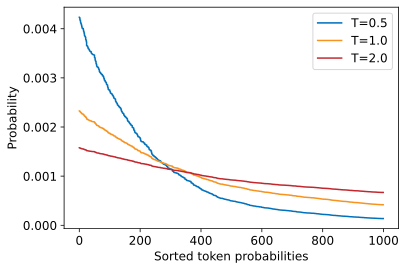

In [27]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [28]:
# hide
torch.manual_seed(42);

In [29]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

Three Rings for the Elven-kings under the sky Seven for the Dwarf-lords in their
halls of stone Nine for Mortal Men doomed to die One for the Dark Lord on his
dark throne In the Land of Mordor where the Shadows lie.


MP3 Walk Using protagonist receive Peng Fan lessonte storage merger 01
Speechorial Mju Agreement Scroll irrational �rite Continent seafrade Powers
Turner Dorbecue bartender Pumpkin meremavernuild Modconfidence Cureiamond disse
* Runewiting MrTL secured conference stink candy boxer Pompeatell deflation
press Vatican credentials Wrestling 317Thingscture Guillard Ty physician spicy
KimBi66 Scotland Oz at aff da temporou MD6 Canada iterta hashes kilograms
Stellarside Anonymousubby DIY1226Seeing Dillon territnton Gokmin698Director
Flaramble BaldKT sealing electrons HarleyBright Monkware Qomo Trouble catalogue
related Network b Skywolf Brigham� IchigoCtrie illustCH Beerfully Mord 2008
SEOSocial ownpour DA inscription castle shut ZeusDebado beating Column Chief
woes compliance v

In [38]:

output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.63, top_k=0)
print(tokenizer.decode(output_temp[0]))

Three Rings for the Elven-kings under the sky Seven for the Dwarf-lords in their
halls of stone Nine for Mortal Men doomed to die One for the Dark Lord on his
dark throne In the Land of Mordor where the Shadows lie.


The Fellowship of the Ring

In the First Age, the elves and dwarves and men of Middle-earth lived in
harmony.

But the darkness that had once been brought into the world by Sauron came again,
and in the Second Age it was renewed.

In the Third Age, Sauron returned and took the One Ring from the hand of the
king of Gondor.

The Nazgûl, the Ringwraiths, came, and enslaved the Elves and Dwarves and the
Men of Middle-earth.

But the Eagles of Arnor and the Rohirrim of Númenor came to their aid, and they
slew the Nazgûl, and when Sauron had been slain, the One Ring was taken from
him.

In the Fourth Age, the Rings of Power were given to the Nine Rings of the Elves
and the Nine Rings of the Dwarves.

But the Lord of the Rings, the Lord of the Nazgû


In [40]:
# combine sampling and repetition check
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, no_repeat_ngram_size=3,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

Three Rings for the Elven-kings under the sky Seven for the Dwarf-lords in their
halls of stone Nine for Mortal Men doomed to die One for the Dark Lord on his
dark throne In the Land of Mordor where the Shadows lie.


The Fellowship of the Ring

The Ring of the Elves

On the side of the mountain was a door. It was narrow and high, and the light
from it was dim. The door was made of white stone, and its iron hinges were set
in a row. They were so heavy that they could not be moved by any but a dwarf.
Behind the door was a small chamber. Inside was a bed, and on the bed was a man.
He was clad in a long robe of white, and his hair was long and white, as was his
beard. He had a long, thin nose, and a long mouth. He smiled at Frodo, and Frodo
smiled back. Then he said, "I am Sam. Samwise Gamgee."

"You are very old," said Frodo.

Sam shrugged, and looked at the floor. "I grew up with a great deal of work to
do. The world is full of things I am not used to.


## Top-k and Nucleus (top-p) Sampling

methods to restrict sampling in addition/alternative to temperature

### top k: sort tokens by prob descending, pick from the top k
### top p (nucleus): make the cutoff dynamic, i.e. when a certain probability mass in the selection is reached

In [41]:
# hide
torch.manual_seed(42);

In [52]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [53]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

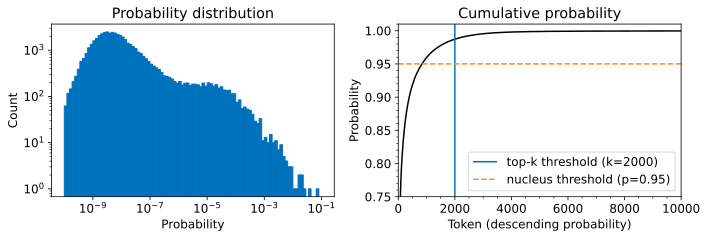

In [44]:

# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [54]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


"This is completely unexpected — even we, a renowned scientist, were completely
unprepared to see unicorns at the top of the Andes Mountains," said biologist
Roberto Goni from the University of Siena, with the study.


The team visited the region in 2012, during the hunt for the first-known
unicorn, found in the Andes Mountains in 1988.


One day, the team saw two unicorns walking in the snow toward them.


"They just appeared in front of us - they were really moving, and they didn't
seem to be frightened of us at all," said Goni.


The team went back to the valley. When they got there, they discovered hundreds
of unicorns. It is the largest herd of unicorns on Earth.


"I couldn't even describe how astonishing this was," Goni told the media. We
were comple

In [55]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The herd, which consists of 11 animals including a white, brown and black one,
are said to be the longest-lived unicorns on the planet. The creatures were
discovered by scientists in a valley in the Andes mountains of Chile, near the
town of La Chancura, in the region of the La Plata basin, which is rich with
precious minerals.

The scientists, who are still unable to identify the herd, have named the
creatures as the Chumacarra herd. They were originally found as a group of eight
animals, but the scientists identified them as a whole herd after their DNA was
sequenced.


The researchers believe the animals, which they named the Chumacarra herd,
probably originated in Argentina, but the scientists also noted that a few of
the animals had a genetic makeup th

In [56]:
# may also combine both methods
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50, top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The study, conducted by a team of French and Argentine researchers, is the first
time that scientists have observed and catalogued wild unicorns in their natural
habitat, in the Andes Mountains in Argentina.

They found that the unicorns, a species known as Thera huanglong, live near a
group of volcanic peaks called La Cerro, in the southern portion of the province
of Cordoba. It is the first time such animals have been observed in this region,
according to the researchers.


"We decided to study these species in the Andes because this is an area with a
very high density of mountains, and with very low density of vegetation, which
provides the ideal environment for the study of wild animals," said Javier
Hidalgo, a researcher of the team that has conducted 

In [57]:
max_length = 254
input_txt = """Three Rings for the Elven-kings under the sky \
Seven for the Dwarf-lords in their halls of stone \
Nine for Mortal Men doomed to die \
One for the Dark Lord on his dark throne \
In the Land of Mordor where the Shadows lie.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [48]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

Three Rings for the Elven-kings under the sky Seven for the Dwarf-lords in their
halls of stone Nine for Mortal Men doomed to die One for the Dark Lord on his
dark throne In the Land of Mordor where the Shadows lie.


H. R. Giger's Dark Forest

A young warrior named Elrond sought to rescue Eowyn, but in the end he had to
become one too.


The House of the Dead

The Lonely Mountain, and the Green Fields where the Dead Walk


Riddles in the Dark

The Lonely Mountain, the Green Fields Where the Dead Walk

Grimoire of the Dead

The Green Fields Where the Dead Walk

The Book of Lost Tales

The Green Fields Where the Dead Walk

In the Green Fields of Mordor, the dead walk, and the living dread and pray

Wandering Dead

The Green Fields Where the Dead Walk

The Book of Lost Tales Part I

Chapter 1: Dead Men and Dead Things


Chapter 1: Dead Men and Dead Things (2 of 2)

The Night Before the Battle of Five Armies

When the forces of darkness were arrayed upon this eve,


In [49]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

Three Rings for the Elven-kings under the sky Seven for the Dwarf-lords in their
halls of stone Nine for Mortal Men doomed to die One for the Dark Lord on his
dark throne In the Land of Mordor where the Shadows lie.


As a child, Saruman's heart was torn by the thought of a new home for the
Dwarves, but the king was wise and did not follow through with it. The elves
gave him their trust and he took it, and took what they had entrusted to him,
and set the dwarves to work with their own hands in his own halls and halls of
stone. He also established a realm for the Elves, and the first of the Nine
Rings, the One Ring, for them.


For the Dwarves it was their new home, as it was for all Men.


But for the Elves the loss of their home was a terrible loss. Their people had
never seen anything so vast and deep and dark, and so much of the earth's heart
was with them as their hearts were with Saruman, but that was not to last.


The Elves had come to the Lonely Mountain to seek the ring of the

In [69]:
# may also combine both methods
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, no_repeat_ngram_size=3,
                             top_k=60, top_p=0.75)
print(tokenizer.decode(output_topp[0]))

Three Rings for the Elven-kings under the sky Seven for the Dwarf-lords in their
halls of stone Nine for Mortal Men doomed to die One for the Dark Lord on his
dark throne In the Land of Mordor where the Shadows lie.


The Third Age of the Earth


This is the Age of Man, the Age when the First Men, Dwarves, and Elves fled from
Mordor to escape the wrath of Sauron.

 is the last age of the earth. After this Age, the earth will no longer have any
life. The First Men and Dwarves will live in the lands that they found in the
First Age, and the Elves and Men will live under the sea. The last of the living
creatures on the earth, the Elves, will be of no use to the Men in their
struggle for domination of the world.

, the last time the First and Second Men left the earth for many ages, is the
time when the Dark lord Sauron, the lord of evil and death, will make his final
stand in Mordor. This is the final age of earth. The Dwarves and Men, who have
escaped Sauron and become his allies, will f

In [50]:
max_length = 254
input_txt = """Cardiovascular Thromboembol Kidney Sarcoma COVID Malignancy \
SCancer Colorectal CRC Extraintestinal Incident Behavior \
COVID Sarcoma Vaccine Malignancy Opportunistic Causation \
Sarcoma COVID Vaccine Malignancy Opportunistic Cardiovascular \
IColorectal Cancer CRC Extraintestinal Behavior Common.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [51]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

Cardiovascular Thromboembol Kidney Sarcoma COVID Malignancy SCancer Colorectal
CRC Extraintestinal Incident Behavior COVID Sarcoma Vaccine Malignancy
Opportunistic Causation Sarcoma COVID Vaccine Malignancy Opportunistic
Cardiovascular IColorectal Cancer CRC Extraintestinal Behavior Common.


I did an extensive search on this, but I am not able to find anything like that.
It seems to be something with a specific syndrome. If someone has a similar
thing that they are searching for, please email me at jake@joshua-anderson.com.
I will look into it.


There may be some sort of disease that I don't have. Maybe one of the symptoms
of this is that I am not very tall for my age. I think this is the first time I
have heard of something like this. I am looking into it.


Thanks.


--

Jake Anderson

M.D.

Clinic for Urologic Oncology

Department of Medicine

Hollis Medical Institute,

Hollis-St. Mary's Hospital

San Diego, California 92101<|endoftext|>
